## Import needed packages


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
!pip install Biopython

## Import Bcd protein gradient

In [2]:
# import Bcd protein gradient lvls from file 
# TF concentration levels from Fowlkes, et al., 2008
FileName = 'C:\\Users\\Rachel2\\Documents\\Limiting Resources project\\Miscelaneous\\TF_concentrations.txt'
TF_Cons = pd.read_csv(FileName,sep='\t', error_bad_lines=False, nrows = 1) #tab deliminated
HalfCon = TF_Cons.loc[0,:] #fraction of max Bcd values
TFVals = HalfCon * 20000  #Total Bcd values, 20000 is max Bcd value

# Setting amount of Bcd molecules per hub 
# This is with 1000 hub-sized regions per nucleus, which comes out to each region being ~510nm diameter
# Assuming 20Bcd molecules per hub, based on Mir, et al., 2017
pHub_20 = np.asarray(HalfCon[1:]) * ((20000/20)/1000) # 20000/20 = 1000 = total TFs / TFs in a hub = # of filled TF hubs. divided by total hub sized regions in nucleus to get probability
#ie the (20000/20)/1000 above is the max p(hub) value, which is multipled by Bcd gradient to determine p(hub) at each position in embryo

## Generate inputs for genome model

In [ ]:
## generate the parameters to pass to the actual modeling script
import itertools 
import numpy as np 


E_s = (np.arange(0,15,2)*-1)#*1.381e-23 *310  ##have in full units, not needing to be mult by kb T 
### Setting dE_ns to 0 
E_ns = (np.arange(0,2,2)*-1)#[0,0]
####Use the actual expected TF values from the Bcd gradient, assuming max of 20000 molecules
TF = [int(x) for x in TFVals[1:100]] #[int(x) for x in TFVals[1:-1]]  
C = np.arange(0,100000,500)
# Remembered that currently assuming E_s == E_c so don't need to iterate thru those values
Pars = [TF, C, E_s, E_ns]
NewList = list(itertools.product(*Pars))

NewArray = np.array(NewList)
# save parameter set - change this filename to what you want
datafile_path = "C:\\Users\\Rachel2\\Documents\\Limiting Resources project\\Modeling\\TestScripts\\BcdGrad_Genome_FirstNew100In.txt"
with open(datafile_path, 'w+') as datafile_id:
#here you open the ascii file

    np.savetxt(datafile_id, NewArray.astype(int))
    #here the ascii file is written

## Genome model code -- run on HPC

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[]:

### HPC calculate pBound value for all given parameters (not a range of TF values)
## calculate pbound for 1 TF value - this will help in making all jobs very short (though will require more jobs)

import decimal 
from decimal import *
import mpmath
import numpy as np
import time
import sys

# use mpmath to deal with big/small numbers
from mpmath import *
mp.dps = 8  #precision to X decimal places

N = int(1e8) #Size of genome for NS binding sites
# pull remaining variables from input parameters file

E_s = int(float(sys.argv[3])) #Binding energy for specific site in E
E_ns = int(float(sys.argv[4])) #Binding energy for non-specific sites
#E_c = int(sys.argv[3]) #Binding energy for competitor sites, here the same as E site
dE = E_s - E_ns

T=int(float(sys.argv[1])) #Number of TF molecules  
C =int(float(sys.argv[2])) #Number of competitor sites, given by input parameters file

#pBound_Syst2 = np.zeros(int(N/10))
SumIt = np.zeros(C)
c=-1
pBound_Syst2=[]

#time how long it takes
start = time.time()

#Calculate pbound for provided parameters
c = +1
mc = -1
SumIt =[]
CompSumIt=[]
SumEq=[]
CompSumEq=[]
SumC=[]
CompSum=[]


if T > C:
    CUse = C
else:
    CUse = T

## 6/5/20 changed to CUse+1 to account for all TFs bound at competitor sites    
for x in range(0,CUse+1):
    if x==T: #if all TFs are bound at competitor sites, can't be bound at E
        SumIt.append(0)
    else:
    ## 5/18/20 changed "c" to "C" in second numerator 
        SumEq = ((N**(T-1-x))/(mpmath.factorial(T-1-x))) * ((mpmath.factorial(C)/(mpmath.factorial(x)*mpmath.factorial(C-x)))) * (mpmath.exp(-((T-1-x)*E_ns + (1+x)*E_s)))
        SumIt.append(SumEq)
    if x==0:  #If no TFs bound at competitor sites, don't double count NS only binding
        CompSumIt.append(0)
    else:
        CompSumEq = (((N**(T-x))/mpmath.factorial(T-x))*(mpmath.factorial(C)/(mpmath.factorial(x)*(mpmath.factorial(C-x))))*(mpmath.exp(-(((T-x)*E_ns) + x*E_s))))
        CompSumIt.append(CompSumEq)
    # double // does integer division 
    
SumC = mpmath.fsum(SumIt)
CompSum = mpmath.fsum(CompSumIt)
NSVal = ((N**T)/mpmath.factorial(T))*mpmath.exp(-(T*E_ns)) #break this out for ease of editing
pBound_Syst2.append(SumC / (NSVal + SumC + CompSum))


elapsed_time_pbound = (time.time() - start)    
#nprint(pBound_Syst2)  #nprint will print the mpf values as numbers, though beware this decreases the decimal precision, but this should be find for just the output 

print(pBound_Syst2[0],sys.argv[1],sys.argv[2],sys.argv[3],sys.argv[4]) #print pBound with the imput parameters to make easier parsing later

## Bash code for genome model

In [ ]:
#!/bin/bash
#$ -N LRTest_Array
#$ -q bio,abio*,free*,pub*  ##Send wherever you can
#$ -pe openmp 1
#$ -ckpt restart
#$ -tc 250 ### save some water for the fishes
#$ -t 2050001-2060000  ### task numbers to send
#$ -e Errors_Syst2.txt
#$ -o Outs_Syst2.txt

module load anaconda/3.7-5.3.0

DIR=/dfs5/bio/rwaymack/TestScripts/TestHCPScripts/BcdGrad_MoreComps_Ins.txt
OUTPUT=/dfs5/bio/rwaymack/TestScripts/TestHCPScripts/Syst2ArrayOutputs/SimOut

b="0"

if [ $SGE_TASK_ID -lt 10 ]
then
    TASKNUMB=$b$SGE_TASK_ID  #add 0 in front of 1-9 for proper sorting
   ## echo "less than 9"
else
    TASKNUMB=$SGE_TASK_ID
fi


ParVals=$(awk "NR==$SGE_TASK_ID " /$DIR)  ##pull parameter values from the list, the row for this task number

python PySyst2_Array.py $ParVals > ${OUTPUT}${TASKNUMB}.txt


## Import genome model data

In [ ]:
# Import the first chunk

import mpmath

#Change this whenever using a different file 
FileName = 'Aug16Outs.txt'


df_InOuts = pd.read_csv(FileName,sep=' ',header=None, error_bad_lines=False)
df_InOuts.columns=["pBound","TF","Competitor","E_s","E_ns"]

## list comprehension to try to change all string values in pBound to mpf values
### general format of list comprehension is [f(x) for x in df['colname']]
MPFpBoundVals =[mpmath.mpf(x) for x in df_InOuts['pBound']] #This gives us a list output 
df_MPFS = pd.DataFrame(MPFpBoundVals)
df_MPFS.columns = ['pBound_mpf']

## Create a column for the ratio of E_s / E_ns
NonZeroE_ns = [int(x) for x in df_InOuts['E_ns']] # convert to integers to allow division
df_IntE_ns_incZeros = pd.DataFrame(NonZeroE_ns)  # Keep different one with zeros for subtraction
IntE_s = [int(x) for x in df_InOuts['E_s']] 
df_IntE_ns = pd.DataFrame(NonZeroE_ns)
df_IntE_s = pd.DataFrame(IntE_s)  # Convert to dataframes to allow for easy replacement of 0's
IntVals = [df_IntE_ns, df_IntE_s, df_IntE_ns_incZeros]
df_IntVals = pd.concat(IntVals,axis = 1)
df_IntVals.columns = ['E_ns','E_s','E_ns w zero']
df_IntVals['E_ns']=df_IntVals['E_ns'].replace(0,1) #Replace 0's with 1's to allow for division, need to 'overwrite' the column 

# list comprehension division of two lists:  result = [a/b for a,b in zip(First_List,Second_List)]
Ratios = [x/y for x,y in zip(df_IntVals['E_s'], df_IntVals['E_ns'])] ## definitely needs to be done like this, quite fast
Diffs = [x - y for x,y in zip(df_IntVals['E_s'], df_IntVals['E_ns w zero'])] # Calc difference, more negative result means stronger specific binding
#Difference values added 6/20/20 bc this may be more meaningful than ratios 

#make into a dataframe to combine all together 
df_Ratios = pd.DataFrame(Ratios)
df_Ratios.columns = ['E_s / E_ns']
df_Diffs = pd.DataFrame(Diffs)
df_Diffs.columns = ['E_s - E_ns']

## combine these dataframes into one 
frames = [df_InOuts,df_Ratios,df_Diffs, df_MPFS]
df_InOutMPF=pd.concat(frames, axis=1)
df_InOutMPF = df_InOutMPF.sort_values('TF')
df_InOutMPF['E_s / E_ns'] = [abs(x) for x in df_InOutMPF['E_s / E_ns']] #absolute value of ratio 
df_InOutMPF['E_s - E_ns'] = [abs(x) for x in df_InOutMPF['E_s - E_ns']] #absolute value of difference (as E_ns is held at 0)
df_InOutMPF

## add column of AP position (based on TF levels)

In [ ]:
#Set what amount of "error" want in # of TFs in an AP bin 
TFRange = 0.005 # x%
#set the TF amounts 
# Try doing with list comprehension 
Numbs = np.arange(1,100,1) #1% to 100% egg length, 0% added below 
Numbs = Numbs.tolist()
TFVals_List = [df_InOutMPF['TF'].between((TFVals[x]-TFVals[x]*TFRange),(TFVals[x] + TFVals[x]*TFRange))for x in Numbs]
# Combine with max and min amounts
conditions_list = [(df_InOutMPF['TF'] == df_InOutMPF['TF'].max())] + TFVals_List + [df_InOutMPF['TF'] == df_InOutMPF['TF'].min()]

# #set the corresponding AP position
outputs_list = [int(x) for x in Numbs]
# also combine with max and min
outputs_list = [int(0)]+ outputs_list + [int(100)] #ie inc 0% and 100% egg length
# #Create a new column representing these 
res_2 = np.select(conditions_list, outputs_list,110)
res_2 = list(map(int,res_2)) # change from string to int 
col_2 = pd.Series(res_2)
df_InOutMPF = df_InOutMPF.assign(AP = col_2.values)
# If not falling into any of the AP bins, and low amt of TF's, just put at 100%
# syntax is weird but do df.loc[(row index),(col index)] = value when want to set equal to a value
# Bcd molecules at 100% based on 20,000 max at anterior is 800, so safe to assume <=500 is at 100% egg length
df_InOutMPF.loc[(df_InOutMPF['AP']==110) & (df_InOutMPF['TF'] <= 500),'AP'] = 100 
# In case of errors in assigning AP bin
df_InOutMPF.loc[df_InOutMPF['AP']=='nan'] = 110

#save dataframe
## Can change file name if want to save a separate version 
df_InOutMPF.to_csv('CombinedpBound_OutVals.csv',index=False)

## Generate inputs for hub model

In [ ]:
## generate the parameters to pass to the actual modeling script
import itertools 
import numpy as np 

E_s = (np.arange(0,15,2)*-1)# units of kBT
#E_c = (np.arange(0,3,2)*-1)# units of kBT
### Setting dE_ns to 0 
E_ns = (np.arange(0,2,2)*-1)#[0,0]
####Using expected Bcd molecules per hub still on same gradient as full Bcd levels
## 11/27/20 Using the much smaller cap of # of Bcd per hub = 20 
TF = [int(x) for x in BcdPerHub_Lowish[1:100]] #[int(x) for x in TFVals[1:-1]]  
## Set non-specific sites to safe upper bound of 40% of genome = 4e7
## Then set upper bound for C sites as 40% what did for whole genome = 40,000
## 11/29/20 setting to same 1:1000 max ratio did as w whole genome so 100
C = np.arange(0,100,1)
# Remembered that currently assuming E_s == E_c so don't need to iterate thru those values
Pars = [TF, C, E_s, E_ns]
NewList = list(itertools.product(*Pars))

NewArray = np.array(NewList)
# save parameter set
datafile_path = "C:\\Users\\Rachel2\\Documents\\Limiting Resources project\\Modeling\\TestScripts\\BcdGrad_PerHubs_Lowish.txt"
with open(datafile_path, 'w+') as datafile_id:
#here you open the ascii file

    np.savetxt(datafile_id, NewArray.astype(int))
    #here the ascii file is written

### Bash script to call Hub model

In [ ]:
#!/bin/bash
#SBATCH --job-name=LRTest_Array
#SBATCH -A rwaymack  ##account to charge
#SBATCH -p standard  ## partition/queue to use
#SBATCH --nodes=1
#SBATCH --array=10-800 ### task numbers to send
#SBATCH --cpus-per-task=1  ### number of cores each job needs
#SBATCH --error=Errors_Syst2.txt  ## where to send errors
#SBATCH --output=Outs_Syst2.txt

module load anaconda/2020.07 ##anaconda/3.7-5.3.0
## set DIR to input file generated above
## Set output to where you want the model outputs saved
DIR=/pub/rwaymack/LimitingResource/ConstantTFHubInput.txt ##/dfs5/bio/rwaymack/TestScripts/TestHCPScripts/HPCScripts/BcdGrad_Ant_LessAPs_Ins.txt
OUTPUT=/pub/rwaymack/LimitingResource/Syst2ArrayOutputs/SimOut

b="0"

if [ $SLURM_ARRAY_TASK_ID -lt 10 ]
then
    TASKNUMB=$b$SLURM_ARRAY_TASK_ID  #add 0 in front of 1-9 for proper sorting
   ## echo "less than 9"
else
    TASKNUMB=$SLURM_ARRAY_TASK_ID
fi


ParVals=$(awk "NR==$SLURM_ARRAY_TASK_ID " /$DIR)  ##pull parameter values from the list, the row for this task number

python PySyst_Hubs.py $ParVals > ${OUTPUT}${TASKNUMB}.txt


## Hub model -- run on HPC

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[]:

### HPC calculate pBound value for all given parameters (not a range of TF values)
## calculate pbound for 1 TF value ? I think this will help in making all jobs very short (though will require more jobs)
### import python 
###module load anaconda/3.7-5.3.0

import decimal 
from decimal import *
import mpmath
import numpy as np
import time
import sys

# use mpmath to deal with big/small numbers
from mpmath import *
mp.dps = 8  #precision to X decimal places

N = int(1e4)## Edited 1/7/21 to test a lower order of mag NS sites in hub  #Based on 2x svb locus from Tsai paper (2018) for NS binding sites within a hub
# pull remaining variables from input parameters file

E_s = int(float(sys.argv[3])) #Binding energy for specific site in E
E_ns = int(float(sys.argv[4])) #Binding energy for non-specific sites
#E_c = int(sys.argv[3]) #Binding energy for competitor sites, here the same as E site
dE = E_s - E_ns

T= 20 #Constant value based on Mir, et al., 2017  #int(float(sys.argv[1])) #Number of TF molecules  
C =int(float(sys.argv[2])) #Number of competitor sites, given by input parameters file

#pBound_Syst2 = np.zeros(int(N/10))
SumIt = np.zeros(C)
c=-1
pBound_Syst2=[]

#time how long it takes
start = time.time()

#Calculate pbound for provided parameters
c = +1
mc = -1
SumIt =[]
CompSumIt=[]
SumEq=[]
CompSumEq=[]
SumC=[]
CompSum=[]


if T > C:
    CUse = C
else:
    CUse = T

## 6/5/20 changed to CUse+1 to account for all TFs bound at competitor sites    
for x in range(0,CUse+1):
    if x==T: #if all TFs are bound at competitor sites, can't be bound at E
        SumIt.append(0)
    else:
    ## 5/18/20 changed "c" to "C" in second numerator 
        SumEq = ((N**(T-1-x))/(mpmath.factorial(T-1-x))) * ((mpmath.factorial(C)/(mpmath.factorial(x)*mpmath.factorial(C-x)))) * (mpmath.exp(-((T-1-x)*E_ns + (1+x)*E_s)))
        SumIt.append(SumEq)
    if x==0:  #If no TFs bound at competitor sites, don't double count NS only binding
        CompSumIt.append(0)
    else:
        CompSumEq = (((N**(T-x))/mpmath.factorial(T-x))*(mpmath.factorial(C)/(mpmath.factorial(x)*(mpmath.factorial(C-x))))*(mpmath.exp(-(((T-x)*E_ns) + x*E_s))))
        CompSumIt.append(CompSumEq)
    # double // does integer division 
    
SumC = mpmath.fsum(SumIt)
CompSum = mpmath.fsum(CompSumIt)
NSVal = ((N**T)/mpmath.factorial(T))*mpmath.exp(-(T*E_ns)) #break this out for ease of editing
pBound_Syst2.append(SumC / (NSVal + SumC + CompSum))


elapsed_time_pbound = (time.time() - start)    
#nprint(pBound_Syst2)  #nprint will print the mpf values as numbers, though beware this decreases the decimal precision, but this should be find for just the output 

print(pBound_Syst2[0],T,sys.argv[2],sys.argv[3],sys.argv[4]) #print pBound with the imput parameters to make easier parsing later


## Import raw hub model data

In [ ]:

import mpmath

#Change this whenever using a different file 
FileName = 'Dec16_ConstTF_Outs.txt'

df_InOuts = pd.read_csv(FileName,sep=' ',header=None, error_bad_lines=False)
df_InOuts.columns=["pBound","TF","Competitor","E_s","E_ns"]

## list comprehension to try to change all string values in pBound to mpf values
### general format of list comprehension is [f(x) for x in df['colname']]
MPFpBoundVals =[mpmath.mpf(x) for x in df_InOuts['pBound']] #This gives us a list output 
df_MPFS = pd.DataFrame(MPFpBoundVals)
df_MPFS.columns = ['pBound_mpf']

## Create a column for the ratio of E_s / E_ns
NonZeroE_ns = [int(x) for x in df_InOuts['E_ns']] # convert to integers to allow division
df_IntE_ns_incZeros = pd.DataFrame(NonZeroE_ns)  # Keep different one with zeros for subtraction
IntE_s = [int(x) for x in df_InOuts['E_s']] 
df_IntE_ns = pd.DataFrame(NonZeroE_ns)
df_IntE_s = pd.DataFrame(IntE_s)  # Convert to dataframes to allow for easy replacement of 0's
IntVals = [df_IntE_ns, df_IntE_s, df_IntE_ns_incZeros]
df_IntVals = pd.concat(IntVals,axis = 1)
df_IntVals.columns = ['E_ns','E_s','E_ns w zero']
df_IntVals['E_ns']=df_IntVals['E_ns'].replace(0,1) #Replace 0's with 1's to allow for division, need to 'overwrite' the column 

# list comprehension division of two lists:  result = [a/b for a,b in zip(First_List,Second_List)]
Ratios = [x/y for x,y in zip(df_IntVals['E_s'], df_IntVals['E_ns'])] ## definitely needs to be done like this, quite fast
### note that differences are absolute value -- 20201124 RW
Diffs = [abs(x - y) for x,y in zip(df_IntVals['E_s'], df_IntVals['E_ns w zero'])] # Calc difference, more negative result means stronger specific binding

#make into a dataframe to combine all together 
df_Ratios = pd.DataFrame(Ratios)
df_Ratios.columns = ['E_s / E_ns']
df_Diffs = pd.DataFrame(Diffs)
df_Diffs.columns = ['E_s - E_ns']

## combine these dataframes into one 
frames = [df_InOuts,df_Ratios,df_Diffs, df_MPFS]
df_InOutMPF_Hub=pd.concat(frames, axis=1)
df_InOutMPF_Hub = df_InOutMPF_Hub.sort_values('TF')
df_InOutMPF_Hub['E_s / E_ns'] = [abs(x) for x in df_InOutMPF_Hub['E_s / E_ns']] #absolute value of ratio 
df_InOutMPF_Hub

## Incorporate AP position to hub model data (based on total TF)

In [ ]:
# need to expand dataframe to have every possible combination of competitors and E strengths at each AP bin 
## (Since the # of TFs/hub is constant across the embryo, ie 20)

## repeat each 100 times (for each embryo position, 0-100)
Test_df = df_InOutMPF_Hub.loc[df_InOutMPF_Hub.index.repeat(100)].reset_index(drop=True)
## Now need to add in the 0-100 AP position for each row in a new column 
x = np.arange(0,100)
x = x.tolist()
n = len(df_InOutMPF_Hub)
# Multiply a list to repeat it n # of times 
Helo = x * n
df_Hubs = Test_df
# Add this AP list as a new column 
df_Hubs['AP'] = Helo
df_Hubs

# at each AP position in pBound dataframe, need to multiply the pbound value by the pHub value for that AP position
# for loop seems most obvious, might be more pythonic way of doing it though 
Numbs = np.arange(0,101,1)
Numbs = Numbs.tolist()
APList = [df_Hubs['AP'] == x for x in Numbs]

# Set corresponding AP position
outputs_list = [x for x in pHub_20]
conditions_list = APList
# #Create a new column representing these 
res_2 = np.select(conditions_list, outputs_list,-1)
#res_2 = list(map(int,res_2)) # change from string to int 
col_2 = pd.Series(res_2)
df_InOutMPF_HubTry = df_Hubs.assign(pHubBound_20 = col_2.values)

## multiply the pHub by pBound values for each row 
lenVal = np.arange(0, len(df_InOutMPF_HubTry)) #number of rows
#pbound is first column, phub is column 9 
pHubBoundVals_20 = [df_InOutMPF_HubTry.iloc[x,0] * df_InOutMPF_HubTry.iloc[x,9] for x in lenVal]
col_20 = pd.Series(pHubBoundVals_20)

#df_InOutMPF_HubTry = df_Hub.assign(pHubBound_Mir = col_Mir.values)
df_InOutMPF_HubTry = df_Hubs.assign(pHubBound_20 = col_20.values)

#re-name
df_HubsReal = df_InOutMPF_HubTry

#save dataframe
## Can change file name if want to save a separate version 
df_HubsReal.to_csv('HubpBound.csv',index=False)

## Import processed Genome model data

In [3]:
## Open the saved file -- will need to change this to match your file's name
FileName = 'CombinedpBound_OutVals.csv'
df_InOutMPF = pd.read_csv(FileName,error_bad_lines=False)
df_InOutMPF

,AP,Competitor,E_ns,E_s,E_s - E_ns,E_s / E_ns,TF,abs(E_s - E_ns),pBound,pBound_mpf
0,100.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.000000,0.000000
1,100.0,650.0,-2.0,-4.0,2,2.0,0.0,2.0,0.000000,0.000000
2,100.0,6700.0,0.0,-4.0,4,4.0,0.0,4.0,0.000000,0.000000
3,100.0,6700.0,-2.0,-2.0,0,1.0,0.0,0.0,0.000000,0.000000
4,100.0,6700.0,0.0,-2.0,2,2.0,0.0,2.0,0.000000,0.000000
5,100.0,6700.0,-2.0,0.0,2,0.0,0.0,2.0,0.000000,0.000000
6,100.0,6700.0,0.0,0.0,0,0.0,0.0,0.0,0.000000,0.000000
7,100.0,6650.0,-2.0,-14.0,12,7.0,0.0,12.0,0.000000,0.000000
8,100.0,6700.0,-2.0,-4.0,2,2.0,0.0,2.0,0.000000,0.000000
9,100.0,6650.0,0.0,-14.0,14,14.0,0.0,14.0,0.000000,0.000000


## Import processed hub model data

In [4]:
### Load the saved hub dataframe
## Open the saved file
FileName = 'HubpBound.csv'
df_HubsReal = pd.read_csv(FileName,error_bad_lines=False)
df_HubsReal

,pBound,TF,Competitor,E_s,E_ns,E_s / E_ns,E_s - E_ns,pBound_mpf,AP,pHubBound_20
0,0.000200,20,0.0,0.0,0.0,0.0,0,0.000200,0,0.000183
1,0.000200,20,0.0,0.0,0.0,0.0,0,0.000200,1,0.000182
2,0.000200,20,0.0,0.0,0.0,0.0,0,0.000200,2,0.000180
3,0.000200,20,0.0,0.0,0.0,0.0,0,0.000200,3,0.000178
4,0.000200,20,0.0,0.0,0.0,0.0,0,0.000200,4,0.000173
5,0.000200,20,0.0,0.0,0.0,0.0,0,0.000200,5,0.000168
6,0.000200,20,0.0,0.0,0.0,0.0,0,0.000200,6,0.000162
7,0.000200,20,0.0,0.0,0.0,0.0,0,0.000200,7,0.000156
8,0.000200,20,0.0,0.0,0.0,0.0,0,0.000200,8,0.000150
9,0.000200,20,0.0,0.0,0.0,0.0,0,0.000200,9,0.000144


## Calculate % decrease in pBound as fx of added competitor sites

In [83]:
# For a given AP bin and E difference, get the % change in pBound from max for the genome and hub models 
APBin = 27 #Choose % EL to look at. 0 = anterior. 
EDiff = 10 # Choose E difference btwn specific and NS sites

Bkgd_Genome = 2000 #Set the number of "background" sites
Bkgd_Hub = 2 #Set the number of "background" sites in each hub 

#Initialize lists
PercDec_Hub =[]
CompHubs =[]
PercMax_Hub =[1]
AdditSites_Hub=[0]
PercDec_Genome=[]
CompGenome=[]
PercMax_Genome=[1]
AdditSites_Genome=[0]

#Grab the rows meeting above qualifications
Sub_Hub = df_HubsReal.loc[(df_HubsReal['AP']==APBin) & (df_HubsReal['E_s - E_ns']==EDiff)]
# Same for genome-model
Sub_Genome = df_InOutMPF.loc[(df_InOutMPF['AP']==APBin) & (df_InOutMPF['E_s - E_ns']==EDiff) & (df_InOutMPF['E_ns']==0)]
Sub_Genome = Sub_Genome.drop_duplicates()

#Find what the max pbound value is for the genome and hub models at specified %EL and EDiff
Sub_Bkgd_Hub = Sub_Hub.loc[(Sub_Hub['Competitor']==Bkgd_Hub)]
MaxHub = Sub_Bkgd_Hub['pHubBound_20'].max()

Sub_Bkgd_Genome = Sub_Genome.loc[(Sub_Genome['Competitor']==Bkgd_Genome)]
MaxGenome = Sub_Bkgd_Genome['pBound'].max()
counter =0
#Now go through # of Comp sites in order and calc the % decrease in pBound from the max of that model 
for x in range(Bkgd_Hub,100):
    counter = counter+1
    TestHub = Sub_Hub.loc[(Sub_Hub['Competitor']==x)]
    #df[condition].iloc[0] gives the first row where condition is true
    if not TestHub.empty:
        TestHub = Sub_Hub[Sub_Hub['Competitor']==x].iloc[0]['pHubBound_20'] #get pBound value
        #TestHub = TestHub['pHubBound_20']
        PercDec_Hub.append((MaxHub - TestHub)/MaxHub)
        CompHubs.append(x)
        # Record % of max
        PercMax_Hub.append(TestHub / MaxHub)
        AdditSites_Hub.append(counter)

counter = 0
# Genome, first do 1st 100 competitor sites, as all reporter constructs have less than 100 Bcd sites
for x in range(2000,2100):
    counter=counter+1
     # Same for genome 
    TestGenome = Sub_Genome.loc[(Sub_Genome['Competitor']==x)]
    if not TestGenome.empty:
        TestGenome = Sub_Genome[Sub_Genome['Competitor']==x].iloc[0]['pBound'] # Gives first row where condition is true, and the [-2] is the position of pBound
        PercDec_Genome.append(((MaxGenome - TestGenome)/MaxGenome))
        CompGenome.append(x)
        PercMax_Genome.append(TestGenome / MaxGenome)
        AdditSites_Genome.append(counter)
    
# For genome, need higher comp numbers
for y in range(2000,100000,500):
    counter=counter+500
    # Same for genome 
    TestGenome = Sub_Genome.loc[(Sub_Genome['Competitor']==y)]
    if not TestGenome.empty:
        TestGenome = Sub_Genome[Sub_Genome['Competitor']==y].iloc[0]['pBound'] # Gives first row where condition is true, and the [-2] is the position of pBound
#     else:
#         TestGenome = TestGenome.drop_duplicates()
    #TestGenome = float(TestGenome['pBound'])
    #Don't double count when competitors are 0 
        if not y == 0:  
            PercDec_Genome.append(((MaxGenome - TestGenome)/MaxGenome))
            CompGenome.append(y)
            PercMax_Genome.append(TestGenome / MaxGenome)
            AdditSites_Genome.append(counter)
    


In [60]:
min(PercMax_Hub, key=lambda x:abs(x-Hb_Homozy))
min(range(len(PercMax_Hub)),key=lambda x:abs(PercMax_Hub[x]-Hb_Homozy))
PercMax_Hub[22]

0.7260855113911086

## Hub model - fraction max pBound as fx of added competitor sites

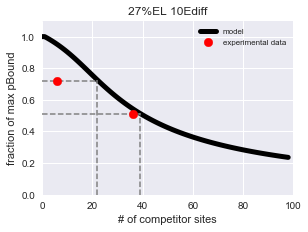

In [65]:
### Hub model plot % max pBound vs # competitor sites 
plt.style.use('seaborn')
plt.figure(figsize=(4.5, 3.2))
plt.rc('font', size=12)          # controls default text sizes
plt.rc('legend', fontsize=8)    # legend fontsize

# Fraction of max expression seen with 2nd reporter / Bcd binding site array 
Hb_Homozy = 0.72  # Taken from experimental value
Hb_6xBcd = 0.51   # Taken from experimental value 

#Find closest model prediction to experimental value
ModVal_HbHomz = min(PercMax_Hub, key=lambda x:abs(x-Hb_Homozy))
Idx_HbHom= min(range(len(PercMax_Hub)),key=lambda x:abs(PercMax_Hub[x]-Hb_Homozy))

ModVal_Hb6xBcd = min(PercMax_Hub, key=lambda x:abs(x-Hb_6xBcd))
Idx_Hb6xBcd= min(range(len(PercMax_Hub)),key=lambda x:abs(PercMax_Hub[x]-Hb_6xBcd))


plt.plot(AdditSites_Hub, PercMax_Hub, c='k', label= 'model', zorder=1,lw=5)
plt.ylabel('fraction of max pBound')
plt.xlabel('# of competitor sites')
plt.title(str(APBin) + '%EL' + ' ' + str(EDiff)+ 'Ediff')


#Show what model predicts required number of sites are
plt.vlines(AdditSites_Hub[Idx_HbHom], 0, PercMax_Hub[Idx_HbHom],linestyles='--',colors=[0.5,0.5,0.5],lw=1.5)
plt.hlines(Hb_Homozy,0, AdditSites_Hub[Idx_HbHom], linestyles='--',colors=[0.5,0.5,0.5],lw=1.5)
plt.hlines(Hb_6xBcd, 0, AdditSites_Hub[Idx_Hb6xBcd], linestyles='--', colors=[0.5,0.5,0.5],lw=1.5)
plt.vlines(AdditSites_Hub[Idx_Hb6xBcd], 0, PercMax_Hub[Idx_Hb6xBcd], linestyles='--',colors=[0.5,0.5,0.5],lw=1.5)

# Plot experimental HbP2 data points
plt.scatter(AdditSites_Hub[6],Hb_Homozy,s=300,c='r',marker='.',label='experimental data',zorder=3)
plt.scatter(AdditSites_Hub[36],Hb_6xBcd,s=300,c='r', marker='.',zorder=3) #label ='HbP2 w 6xBcd', zorder=2)

plt.legend()
plt.ylim(0,1.1)
plt.xlim(0,100)


#save figure
plt.savefig('HubwBkgd_'+str(APBin)+'EL'+str(EDiff)+'Ediff.svg')

In [85]:
PercMax_Hub[36]

0.5446373930730402

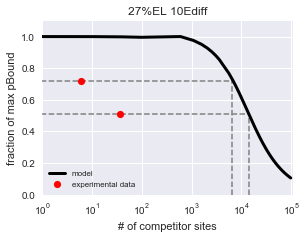

In [66]:
### Genome model plot % max pBound vs # competitor sites

#Find closest model prediction to experimental value
GModVal_HbHomz = min(PercMax_Genome, key=lambda x:abs(x-Hb_Homozy))
GIdx_HbHom= min(range(len(PercMax_Genome)),key=lambda x:abs(PercMax_Genome[x]-Hb_Homozy))

GModVal_Hb6xBcd = min(PercMax_Genome, key=lambda x:abs(x-Hb_6xBcd))
GIdx_Hb6xBcd= min(range(len(PercMax_Genome)),key=lambda x:abs(PercMax_Genome[x]-Hb_6xBcd))

plt.figure(figsize=(4.5, 3.2))
plt.rc('font', size=12)          # controls default text sizes
plt.rc('legend', fontsize=8)    # legend fontsize

# Plot model prediction
plt.plot(AdditSites_Genome, PercMax_Genome, c='k', label='model',lw=3)
plt.ylabel('fraction of max pBound')
plt.xlabel('# of competitor sites')
plt.title(str(APBin) + '%EL' + ' ' + str(EDiff)+ 'Ediff')

# Plot HbP2 experimental data
plt.scatter(AdditSites_Genome[3],Hb_Homozy,s=200,c='r',marker='.',label='experimental data', zorder=3, linewidths=0.1)#'Homozygous HbP2')
plt.scatter(AdditSites_Genome[9],Hb_6xBcd,s=200,c='r', marker='.', zorder=3, linewidths=0.1)#, label ='HbP2 w 6xBcd', zorder=2)

#Show what model predicts required number of sites are
plt.vlines(AdditSites_Genome[GIdx_HbHom], 0, PercMax_Genome[GIdx_HbHom],linestyles='--',colors=[0.5,0.5,0.5],lw=1.5) #got 4000 by seeing fell btwn 28 and 29 which was 3600 sites and 5000
plt.hlines(Hb_Homozy,0, AdditSites_Genome[GIdx_HbHom], linestyles='--',colors=[0.5,0.5,0.5],lw=1.5)
plt.hlines(Hb_6xBcd, 0, AdditSites_Genome[GIdx_Hb6xBcd], linestyles='--', colors=[0.5,0.5,0.5],lw=1.5)
plt.vlines(AdditSites_Genome[GIdx_Hb6xBcd], 0, PercMax_Genome[GIdx_Hb6xBcd], linestyles='--',colors=[0.5,0.5,0.5],lw=1.5)


plt.xscale('log')
plt.legend()
plt.ylim(0,1.1)
plt.xlim(1,1.1e5)

#save figure
plt.savefig('GenomewBkgd'+str(APBin)+'EL'+str(EDiff)+'Ediff.svg')

In [100]:
AdditSites_Genome[46]

14100

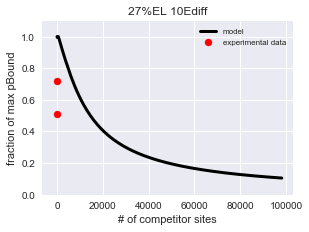

In [68]:
### Inset of genome model with linear X axis

plt.figure(figsize=(4.5, 3.2))
plt.rc('font', size=12)          # controls default text sizes
plt.rc('legend', fontsize=8)    # legend fontsize

plt.plot(AdditSites_Genome, PercMax_Genome, c='k', label='model',lw=3)
plt.ylabel('fraction of max pBound')
plt.xlabel('# of competitor sites')
plt.title(str(APBin) + '%EL' + ' ' + str(EDiff)+ 'Ediff')

# Plot HbP2 data points
plt.scatter(AdditSites_Genome[3],Hb_Homozy,s=200,c='r',marker='.',label='experimental data', zorder=3)#'Homozygous HbP2')
plt.scatter(AdditSites_Genome[9],Hb_6xBcd,s=200,c='r', marker='.', zorder=3)#, label ='HbP2 w 6xBcd', zorder=2)

plt.legend()
plt.ylim(0,1.1)


#save figure
plt.savefig('GenomewBkgdLinearX'+str(APBin)+'EL'+str(EDiff)+'Ediff.svg')


### Supplemental plots

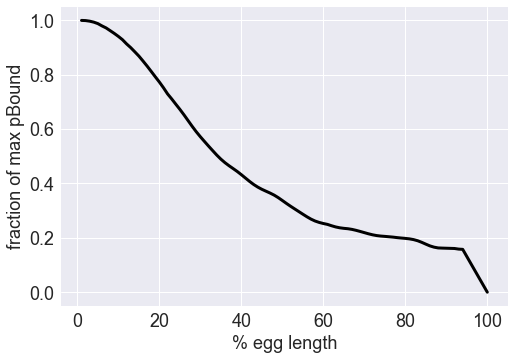

In [111]:
# Genome model, pBound as fx of TF levels
plt.rc('font', size=12)          # controls default text sizes
plt.rc('legend', fontsize=8)    # legend fontsize

EDiffUse = 10 #Hold diff in binding energies constant
CompSites = 2000 # Hold competitor sites constant at "background" level

# Get all simulated data points with above requirements
Sub_Genome = df_InOutMPF.loc[(df_InOutMPF['E_s - E_ns']==EDiffUse) & (df_InOutMPF['Competitor']==CompSites) & (df_InOutMPF['AP'] < 110)]
Sub_Genome = Sub_Genome.drop_duplicates()

# Find max pBound for specified Ediff and competitor sites
MaxGenome = Sub_Genome['pBound'].max()
MaxRow = Sub_Genome.loc[(Sub_Genome['pBound']==MaxGenome)]
MaxAP = MaxRow['AP'].values[0] #This should be 1 

# initialize things
APBinGenome =[]
PercMax_Genome =[]

# Go through TF values in desending order & calc fraction of max pBound from above
counter = 0
for x in range(1,101):
    counter = counter+1
    TestGenome = Sub_Genome.loc[(Sub_Genome['AP']==x)]
    if not TestGenome.empty:
        TestGenome = Sub_Genome[Sub_Genome['AP']==x].iloc[0]['pBound']
        APBinGenome.append(x)
        PercMax_Genome.append(TestGenome / MaxGenome)
        
        
# plot figure
plt.plot(APBinGenome, PercMax_Genome,c='k', label= 'genome model',zorder=1, lw=3)
plt.ylabel('fraction of max pBound',fontsize=18)
plt.xlabel('% egg length',fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

#save figure
plt.savefig('GenomepBoundfxTF'+str(CompSites)+'competitors'+str(EDiff)+'Ediff.svg')

Text(0.5, 0, 'specific - nonspecific binding E diff')

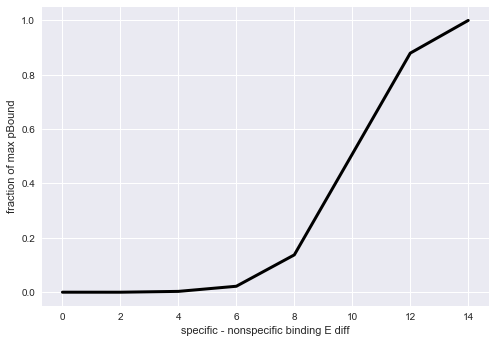

In [38]:
# Genome model, pBound as fx of specific vs non-specific binding E difference
APBin = 27 #Choose %EL to use, 0 = anterior
CompSites = 2000 # Hold competitor sites constant at "background" level

# Get all simulated data points with above requirements
Sub_Genome = df_InOutMPF.loc[(df_InOutMPF['AP']==APBin) & (df_InOutMPF['Competitor']==CompSites) & (df_InOutMPF['AP'] < 110)]
Sub_Genome = Sub_Genome.drop_duplicates()

# Find max pBound for specified Ediff and competitor sites
MaxGenome = Sub_Genome['pBound'].max()

# initialize things
EDiffGenome =[]
PercMax_Genome =[]

# Go through TF values in desending order & calc fraction of max pBound from above
counter = 0
for x in range(0,20):
    counter = counter+1
    TestGenome = Sub_Genome.loc[(Sub_Genome['E_s - E_ns']==x)]
    if not TestGenome.empty:
        TestGenome = Sub_Genome[Sub_Genome['E_s - E_ns']==x].iloc[0]['pBound']
        EDiffGenome.append(x)
        PercMax_Genome.append(TestGenome / MaxGenome)
        
        
# plot data
plt.plot(EDiffGenome, PercMax_Genome, c='k', label= 'genome model', zorder=1,lw=3)
plt.ylabel('fraction of max pBound',fontsize=18)
plt.xlabel('specific - nonspecific binding E diff',fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

# Save figure
#plt.savefig('GenomepBoundfxEDiff'+str(CompSites)+'competitors'+str(APBin)+'EL.svg')

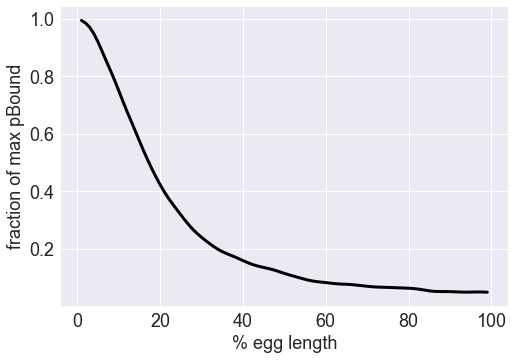

In [112]:
# Hub model, pBound as fx of TF levels
plt.rc('font', size=28)          # controls default text sizes

EDiffUse = 10 #Hold diff in binding energies constant
CompSites = 2 # Hold competitor sites constant at "background" level

# Get all simulated data points with above requirements
Sub_Hub = df_HubsReal.loc[(df_HubsReal['E_s - E_ns']==EDiffUse) & (df_HubsReal['Competitor']==CompSites) & (df_HubsReal['AP'] < 110)]
Sub_Hub = Sub_Hub.drop_duplicates()

# Find max pBound for specified Ediff and competitor sites
MaxHub = Sub_Hub['pHubBound_20'].max()
MaxRow = Sub_Hub.loc[(Sub_Hub['pHubBound_20']==MaxHub)]
MaxAP = MaxRow['AP'].values[0] #This should be 1 

# initialize things
APBinHub =[]
PercMax_Hub =[]

# Go through TF values in desending order & calc fraction of max pBound from above
counter = 0
for x in range(1,101):
    counter = counter+1
    TestHub = Sub_Hub.loc[(Sub_Hub['AP']==x)]
    if not TestHub.empty:
        TestHub = Sub_Hub[Sub_Hub['AP']==x].iloc[0]['pHubBound_20']
        APBinHub.append(x)
        PercMax_Hub.append(TestHub / MaxHub)
        
        

# plot data
plt.plot(APBinHub, PercMax_Hub, c='k', label= 'hub model', zorder=1,lw=3)
plt.ylabel('fraction of max pBound', fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('% egg length', fontsize=18)
plt.xticks(fontsize=18)

# save figure
plt.savefig('HubfxTF_'+str(CompSites)+'Competitors'+str(EDiff)+'Ediff.svg')


Text(0.5, 0, 'abs(specific - nonspecific binding energy)')

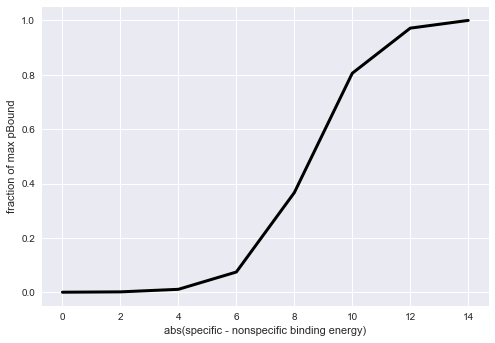

In [40]:
# Hub model, pBound as fx of binding E difference
APBin = 27 #Hold embryo position (ie TF number) constant
CompSites = 2 # Hold competitor sites constant at "background" level

# Get all simulated data points with above requirements
Sub_Hub = df_HubsReal.loc[(df_HubsReal['AP']==APBin) & (df_HubsReal['Competitor']==CompSites)]
Sub_Hub = Sub_Hub.drop_duplicates()

# Find max pBound for specified Ediff and competitor sites
MaxHub = Sub_Hub['pHubBound_20'].max()


# initialize things
EDiffHub =[]
PercMax_Hub =[]

# Go through TF values in desending order & calc fraction of max pBound from above
counter = 0
for x in range(0,20):
    counter = counter+1
    TestHub = Sub_Hub.loc[(Sub_Hub['E_s - E_ns']==x)]
    if not TestHub.empty:
        TestHub = Sub_Hub[Sub_Hub['E_s - E_ns']==x].iloc[0]['pHubBound_20']
        EDiffHub.append(x)
        PercMax_Hub.append(TestHub / MaxHub)
        
        
# plot data
plt.plot(EDiffHub, PercMax_Hub,c='k', label= 'model', zorder=1,lw=3)
plt.ylabel('fraction of max pBound')
plt.xlabel('abs(specific - nonspecific binding energy)')

# Save figure
#plt.savefig('HubfxEDiff_'+str(APBin)+'EL'+str(CompSites)+'Competitors.svg')

In [46]:
def CalcFractpBound(AP, EDVal, Bkgd):
    """ Calculate Fraction of max pBound as fx of increasing number of competitor sites for the given AP position,
    binding energy difference, and number of "background" sites. 
    
    Parameters
    ----------
    AP : % egg length to use (determines the number of TFs)
    EDVal : difference in binding energy at specific and non-specific sites
    Bkgd : # of background sites in genome. This number is divided by 1000 for hub model.
    
    Returns
    --------
    PercMax_Genome : Array of fraction of max pBound values from the genome model
    AdditSites_Genome : Array of the number of added sites beyond set background used to get pBound value in genome model
    PercMax_Hub : Array of fraction of max pbound values from hub model
    AdditSites_Hub : Array of number of added sites beyond background used to get pBound value in hub model
    
    """ 

    APBin = AP
    EDiff = EDVal
    Bkgd_Genome = int(Bkgd)
    Bkgd_Hub = int(Bkgd / 1000)
    
    
    #Initialize lists
    PercDec_Hub =[]
    CompHubs =[]
    PercMax_Hub =[1]
    AdditSites_Hub=[0]
    PercDec_Genome=[]
    CompGenome=[]
    PercMax_Genome=[1]
    AdditSites_Genome=[0]

    #Grab the rows meeting above qualifications
    Sub_Hub = df_HubsReal.loc[(df_HubsReal['AP']==APBin) & (df_HubsReal['E_s - E_ns']==EDiff)]
    # Same for genome-model
    Sub_Genome = df_InOutMPF.loc[(df_InOutMPF['AP']==APBin) & (df_InOutMPF['E_s - E_ns']==EDiff) & (df_InOutMPF['E_ns']==0)]
    Sub_Genome = Sub_Genome.drop_duplicates()

    #Find what the max pbound value is for the genome and hub models at specified %EL and EDiff
    Sub_Bkgd_Hub = Sub_Hub.loc[(Sub_Hub['Competitor']==Bkgd_Hub)]
    MaxHub = Sub_Bkgd_Hub['pHubBound_20'].max()

    Sub_Bkgd_Genome = Sub_Genome.loc[(Sub_Genome['Competitor']==Bkgd_Genome)]
    MaxGenome = Sub_Bkgd_Genome['pBound'].max()
    counter =0
    #Now go through # of Comp sites in order and calc the % decrease in pBound from the max of that model 
    for x in range(Bkgd_Hub,100):
        counter = counter+1
        TestHub = Sub_Hub.loc[(Sub_Hub['Competitor']==x)]
        #df[condition].iloc[0] gives the first row where condition is true
        if not TestHub.empty:
            TestHub = Sub_Hub[Sub_Hub['Competitor']==x].iloc[0]['pHubBound_20']
            #TestHub = TestHub['pHubBound_20']
            PercDec_Hub.append((MaxHub - TestHub)/MaxHub)
            CompHubs.append(x)
            # Record % of max
            PercMax_Hub.append(TestHub / MaxHub)
            AdditSites_Hub.append(counter)

    counter = 0
    # Genome, first do 1st 100 competitor sites, as all reporter constructs have less than 100 Bcd sites
    for x in range(Bkgd,Bkgd+101,1):
        counter=counter+1
         # Same for genome 
        TestGenome = Sub_Genome.loc[(Sub_Genome['Competitor']==x)]
        if not TestGenome.empty:
            TestGenome = Sub_Genome[Sub_Genome['Competitor']==x].iloc[0]['pBound'] # Gives first row where condition is true, and the [-2] is the position of pBound
            PercDec_Genome.append(((MaxGenome - TestGenome)/MaxGenome))
            CompGenome.append(x)
            PercMax_Genome.append(TestGenome / MaxGenome)
            AdditSites_Genome.append(counter)
    
    # For genome, need higher comp numbers
    for y in range(Bkgd,100000,500):
        counter=counter+500
        # Same for genome 
        TestGenome = Sub_Genome.loc[(Sub_Genome['Competitor']==y)]
        if not TestGenome.empty:
            TestGenome = Sub_Genome[Sub_Genome['Competitor']==y].iloc[0]['pBound'] # Gives first row where condition is true, and the [-2] is the position of pBound
    #     else:
    #         TestGenome = TestGenome.drop_duplicates()
        #TestGenome = float(TestGenome['pBound'])
        #Don't double count when competitors are 0 
            if not y == 0:  
                PercDec_Genome.append(((MaxGenome - TestGenome)/MaxGenome))
                CompGenome.append(y)
                PercMax_Genome.append(TestGenome / MaxGenome)
                AdditSites_Genome.append(counter)
    
    return PercMax_Genome, AdditSites_Genome, PercMax_Hub, AdditSites_Hub 


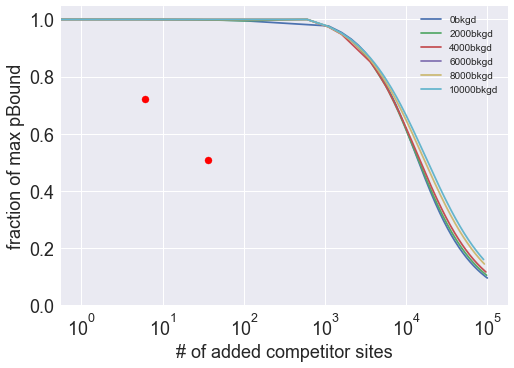

In [125]:
# Effect of different numbers of "background" sites - genome model

# For a given AP bin and E difference, get the % change in pBound from max for the genome and hub models 
APBin = 27 #Choose % EL to look at 
EDiff = 10 # Choose E difference btwn specific and NS sites

Bkgd_Genome = 2000 #Set the number of "background" sites
Bkgd_Hub = 2 #Set the number of "background" sites in each hub 

#plot parameters
plt.rcParams["font.size"] = 12
plt.rc('font', size=12)          # controls default text sizes
plt.rc('legend', fontsize=8)    # legend fontsize
# deal with colors
from matplotlib.pyplot import cm 
color = iter(cm.rainbow(np.linspace(0,1,6)))
colUse=[]
counter = 0
for i in range(6):
    colUse.append(next(color))

fig = plt.figure()
ax = fig
for x in range(0, 12000, 2000):
    counter+1
    [PM_G, AS_G, PM_H, AS_H] = CalcFractpBound(APBin, EDiff, x)
    plt.plot(AS_G, PM_G, label = str(x)+'bkgd')
    plt.xscale('log')


plt.scatter(6,Hb_Homozy,s=200,c='r',marker='.',zorder=3)#'Homozygous HbP2')
plt.scatter(36,Hb_6xBcd,s=200,c='r',marker='.',zorder=3)   
plt.ylabel('fraction of max pBound',fontsize=18)
plt.xlabel('# of added competitor sites',fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=10)

plt.show()
ax.savefig('GenomeDiffBkgd_'+str(APBin)+'EL'+str(EDiff)+'EDiff.svg')

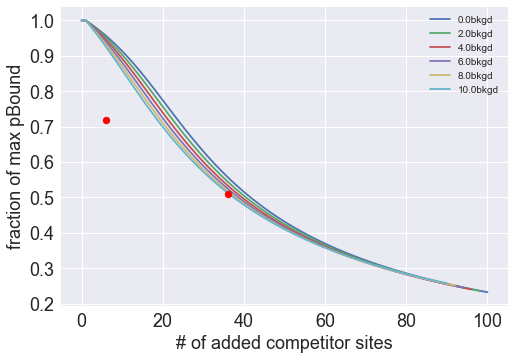

In [124]:
# Effect of different numbers of "background" sites - hub model

# For a given AP bin and E difference, get the % change in pBound from max for the genome and hub models 
APBin = 27 #Choose % EL to look at 
EDiff = 10 # Choose E difference btwn specific and NS sites

Bkgd_Genome = 2000 #Set the number of "background" sites
Bkgd_Hub = 2 #Set the number of "background" sites in each hub 

#plot parameters
plt.rcParams["font.size"] = 12
# deal with colors
from matplotlib.pyplot import cm 
color = iter(cm.rainbow(np.linspace(0,1,6)))
colUse=[]
counter = 0
for i in range(6):
    colUse.append(next(color))

fig = plt.figure()
ax = fig
for x in range(0, 12000, 2000):
    counter+1
    [PM_G, AS_G, PM_H, AS_H] = CalcFractpBound(APBin, EDiff, x)
    plt.plot(AS_H, PM_H, label = str(x/1000)+'bkgd')
    
    

plt.scatter(6,Hb_Homozy,s=200,c='r',marker='.',zorder=3)#'Homozygous HbP2')
plt.scatter(36,Hb_6xBcd,s=200,c='r',marker='.',zorder=3) 
plt.ylabel('fraction of max pBound',fontsize=18)
plt.xlabel('# of added competitor sites',fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=10)
plt.show()
ax.savefig('HubDiffBkgd_'+str(APBin)+'EL'+str(EDiff)+'EDiff.svg')
